# CAM304

## REDES NEURAIS E APRENDIZAGEM EM PROFUNDIDADE

## Rede de Convolução / Visão Computacional (Versão PyTorch)

### Prof. Eduardo Luz / Eduluz@ufop.edu.br

Objetivos:

- Aplicação de filtros em imagens por meio de convolução
- Entendimento do uso de stride, padding e pooling
- Modelagem de uma rede de convolução para o problema de rec. de face da AT&T
- Uso do VGG pré-treinado como um extrator de características
- Uso do MobileNet pré-treinado para classificação de faces : transferência de aprendizagem
- Notebook convertido para PyTorch.

Data da entrega : a ser definido

- Complete o código (marcado com ToDo) e quando requisitado, escreva textos diretamente nos notebooks. Onde tiver *None*, substitua pelo seu código.
- Crie um repositório no github para o grupo e me convide como colaborador (eduluzufop). Por fim, me envie o link do github.


# 1. Aplicando filtros e entendendo padding, stride e pooling (20pt)

## 1.1. Importando pacotes e montando o drive

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, transforms
from torch.utils.data import DataLoader, TensorDataset, random_split

import os
import skimage
from skimage import io
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%matplotlib inline
from skimage.io import imread
from skimage.transform import resize

In [23]:
#%cd '/content/drive/MyDrive/aulas/CURSOS/ITV/CAM304-2025/CAM304_NeuralNet_Material/Práticas/datasets'
#%cd '/content/drive/Shareddrives/'
%cd '/content/drive/MyDrive/datasets/'
%ls

/content/drive/.shortcut-targets-by-id/1PzA6OsAaMGsjswkhoUe2RXk2auC6B9oV/datasets
 AttFaces/        Eye/        test_toldbr.csv
'Cat - NonCat'/   Lenna.png   train_toldbr.csv


In [24]:
%pwd

'/content/drive/.shortcut-targets-by-id/1PzA6OsAaMGsjswkhoUe2RXk2auC6B9oV/datasets'

## 1.2. Carregando uma imagem

Carregue um imagem do disco, para usar como exemplo.

sample image shape:  (512, 512, 3)


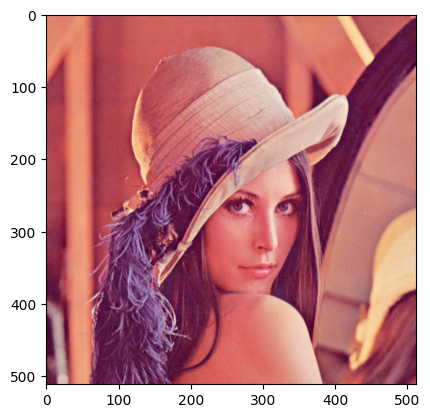

In [25]:
# carrega imagem de exemplo
# Substitua pelo seu caminho no Drive
sample_image = imread("/content/drive/MyDrive/datasets/Lenna.png")
sample_image= sample_image.astype(float)

size = sample_image.shape
print("sample image shape: ", sample_image.shape)

plt.imshow(sample_image.astype('uint8'));

In [26]:
# veja o shape da imagem
print(sample_image.shape)

(512, 512, 3)


## 1.3. Criando e aplicando um filtro com convolução

Utilize o PyTorch para aplicar o filtro. Observe que nesta etapa não há necessidade de treinamento algum. O código abaixo cria uma camada de convolução com 3 filtros de tamanho 5x5, e adiciona padding de forma a manter a imagem de saída (filtrada) do mesmo tamanho da imagem de entrada (padding ="same").

In [27]:
# Cria uma camada de convolução nn.Conv2d.
# PyTorch espera entrada no formato (Batch, Canais, Altura, Largura).
# Nossa imagem é (Altura, Largura, Canais), então precisamos permutar as dimensões.
conv = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=(5, 5), padding="same")

# Vamos verificar a camada
print(conv)

Conv2d(3, 3, kernel_size=(5, 5), stride=(1, 1), padding=same)


In [28]:
# Para ver um sumário similar ao Keras, podemos usar a biblioteca torchinfo
!pip install -q torchinfo
from torchinfo import summary
summary(conv, input_size=(1, 3, 512, 512)) # (Batch, Canais, Altura, Largura)

Layer (type:depth-idx)                   Output Shape              Param #
Conv2d                                   [1, 3, 512, 512]          228
Total params: 228
Trainable params: 228
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 59.77
Input size (MB): 3.15
Forward/backward pass size (MB): 6.29
Params size (MB): 0.00
Estimated Total Size (MB): 9.44

In [29]:
# com PyTorch, as convoluções esperam tensores no formato : (batch_size, channels, height, width).
# Uma imagem isolada é considerada um lote de tamanho 1, portanto, deve-se adicionar uma dimensão de lote (batch) e
# permutar as dimensões de canais, altura e largura.
img_in = torch.from_numpy(sample_image).float()
img_in = img_in.permute(2, 0, 1) # (H, W, C) -> (C, H, W)
img_in = img_in.unsqueeze(0)    # (C, H, W) -> (B, C, H, W) com B=1

print(img_in.shape)

torch.Size([1, 3, 512, 512])


Agora, pode-se aplicar a convolução. Aplique a convolução na imagem de exemplo e verifique o tamanho da imagem resultante (img_out).

In [30]:
img_out = conv(img_in)
print(img_out.shape)

torch.Size([1, 3, 512, 512])


Plote as imagens lado a lado e observe o resultado. O parâmetro `padding="same"` aplica um padding automático no sentido de garantir que a saída tenha o mesmo tamanho da entrada.
Lembre-se que o padding adiciona zeros nas bordas da imagem, antes da aplicação da convolução.

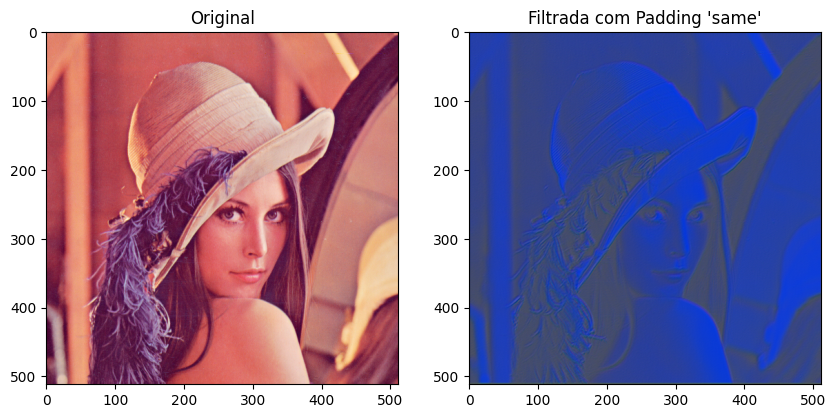

In [31]:
# Para exibir, precisamos reverter as permutações e converter para numpy
img_out_display = img_out.squeeze(0).permute(1, 2, 0).detach().numpy()

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(10, 5))
ax0.imshow(sample_image.astype('uint8'))
ax0.set_title("Original")
# Normalizar a saída para o intervalo [0, 255] para visualização correta
img_out_display_norm = (img_out_display - img_out_display.min()) / (img_out_display.max() - img_out_display.min())
ax1.imshow((img_out_display_norm * 255).astype('uint8'));
ax1.set_title("Filtrada com Padding 'same'");

Repita o mesmo procedimento, trocando padding de 'same' para 'valid' (que é padding=0 em PyTorch), usando apenas um filtro de saída.

In [32]:
conv2 = nn.Conv2d(in_channels=3, out_channels=1, kernel_size=(5, 5), padding="valid") # valid é o mesmo que padding=0
print(conv2)

Conv2d(3, 1, kernel_size=(5, 5), stride=(1, 1), padding=valid)


In [33]:
summary(conv2, input_size=(1, 3, 512, 512)) # 1 filtro 5x5x3 ... a profundidade do filtro é de acordo com a entrada. 5x5x3 = 75; Não esqueça do bias! Total: 75+1=76

Layer (type:depth-idx)                   Output Shape              Param #
Conv2d                                   [1, 1, 508, 508]          76
Total params: 76
Trainable params: 76
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 19.61
Input size (MB): 3.15
Forward/backward pass size (MB): 2.06
Params size (MB): 0.00
Estimated Total Size (MB): 5.21

In [34]:
img_out = conv2(img_in)
print(img_out.shape)

torch.Size([1, 1, 508, 508])


Plote as duas imagens lado a lado

In [35]:
#  Como tivemos que expandir a primeira dimensao para aplicar a convolução, podemos remover a dimensão unitária para plotar a imagem, usando a função squeeze()
i = img_out.squeeze().detach().numpy() # squeeze remove todas as dimensões de tamanho 1
print(i.shape)

(508, 508)


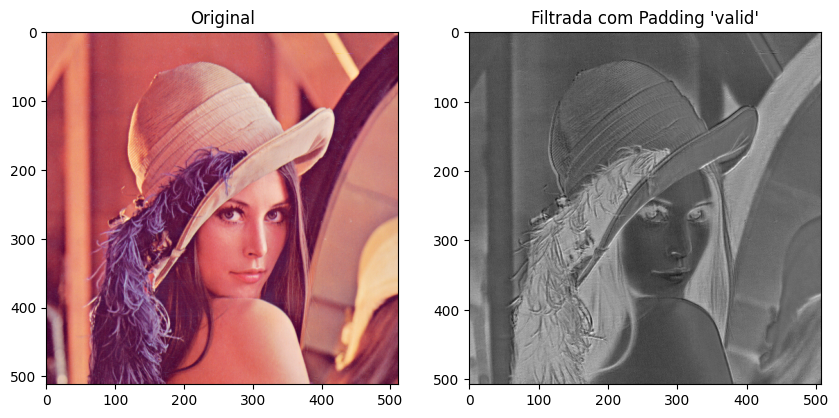

In [36]:
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(10, 5))
ax0.imshow(sample_image.astype('uint8'))
ax0.set_title("Original")
i = img_out.squeeze().detach().numpy()
ax1.imshow(i.astype('uint8'), cmap='gray'); # A saída tem apenas 1 canal, então usamos cmap gray
ax1.set_title("Filtrada com Padding 'valid'");

## 1.4. Inicializando os filtros na mão


A função abaixo inicializa um tensor de dimensões (3, 3, 5, 5) com todas as posições zero, exceto as diagonais, que recebem o valor 1/25. Isso criará um filtro de média (borrão).

In [37]:
def my_filter_tensor():
    # Formato do peso em PyTorch: (out_channels, in_channels, kernel_height, kernel_width)
    shape = (3, 3, 5, 5)
    array = torch.zeros(shape, dtype=torch.float32)
    # Cria um filtro de média 5x5 para cada canal de entrada mapeando para seu canal de saída correspondente
    filter_kernel = torch.ones(5, 5) / 25.0
    array[0, 0, :, :] = filter_kernel # Canal 0 -> Canal 0
    array[1, 1, :, :] = filter_kernel # Canal 1 -> Canal 1
    array[2, 2, :, :] = filter_kernel # Canal 2 -> Canal 2
    return array

In [38]:
# visualizando o filtro
print(my_filter_tensor()[0,0,:,:])

tensor([[0.0400, 0.0400, 0.0400, 0.0400, 0.0400],
        [0.0400, 0.0400, 0.0400, 0.0400, 0.0400],
        [0.0400, 0.0400, 0.0400, 0.0400, 0.0400],
        [0.0400, 0.0400, 0.0400, 0.0400, 0.0400],
        [0.0400, 0.0400, 0.0400, 0.0400, 0.0400]])


In [39]:
# a função definida acima é usada para carregar valores nos filtros.
conv3 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=(5, 5), padding="same", bias=False)

# Carregando os pesos customizados na camada
with torch.no_grad():
    conv3.weight = nn.Parameter(my_filter_tensor())

## 1.5. Plote e observe o que acontece com a imagem (1pt)



A imagem resultante ficou borrada (desfocada), como esperado de um filtro de média. Cada pixel na imagem de saída é a média dos pixels em uma vizinhança 5x5 na imagem original, o que suaviza as transições abruptas e reduz a nitidez.

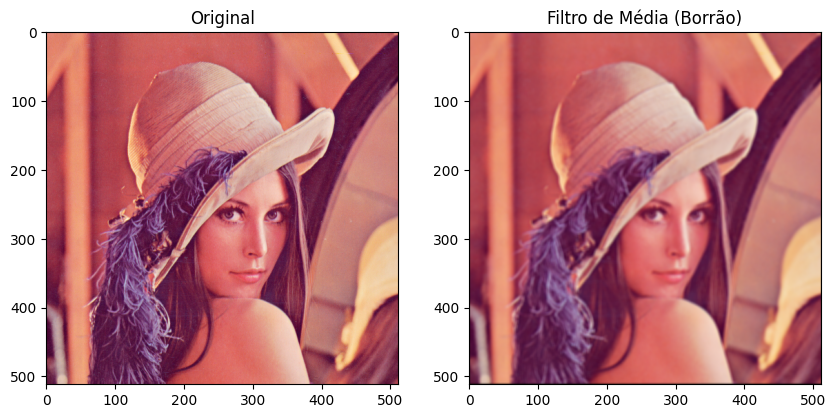

In [40]:
# observe o que acontece com a imagem
img_out_3 = conv3(img_in)
img_out_3_display = img_out_3.squeeze(0).permute(1, 2, 0).detach().numpy()

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(10, 5))
ax0.imshow(sample_image.astype('uint8'))
ax0.set_title("Original")
ax1.imshow(img_out_3_display.astype('uint8'));
ax1.set_title("Filtro de Média (Borrão)");

### Responda

**ToDo** : Descreva suas observações sobre a imagem anterior.

Ao aplicar o filtro de média as bodas e os detalhes finos são suavizados,mantendo as características gerais.

## 1.6. Filtros de borda (5pt)

**ToDo** : Crie uma nova função para gerar um filtro de borda nos 3 canais da imagem de entrada. O filtro deve ser 3x3 e ter o formato [[0, 0.2, 0], [0, -0.2, 0], [0, 0, 0]] (2pt)

In [41]:
def my_new_filter_tensor(shape=(3, 3, 3, 3), dtype=None):
    # Formato do peso em PyTorch: (out_channels, in_channels, kernel_height, kernel_width)
    array = torch.zeros(shape, dtype=torch.float32)

    # Filtro de borda vertical
    filter_kernel = torch.tensor([[0, 0.2, 0], [0, -0.2, 0], [0, 0, 0]], dtype=torch.float32)

    # Aplica o mesmo filtro para cada canal
    for i in range(shape[0]): # out_channels
        for j in range(shape[1]): # in_channels
            if i == j: # Mapeia cada canal de entrada para o seu de saída correspondente
                array[i, j, :, :] = filter_kernel

    return array

Inicialize o objeto conv4 com seu novo filtro e aplique na imagem de entrada

In [42]:
conv4 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=(3, 3), padding="same", bias=False)

with torch.no_grad():
    conv4.weight = nn.Parameter(my_new_filter_tensor(shape=(3,3,3,3)))

Text(0.5, 1.0, 'Filtro de Borda')

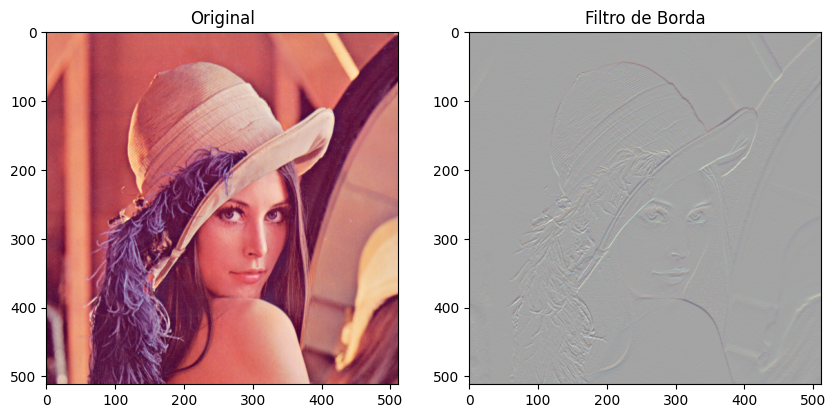

In [43]:
# Plote as duas imagens lado a lado (filtrada e não filtrada)
img_out_4 = conv4(img_in)
img_out_4_display = img_out_4.squeeze(0).permute(1, 2, 0).detach().numpy()

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(10, 5))
ax0.imshow(sample_image.astype('uint8'))
ax0.set_title("Original")
# Normalizar para exibição
img_out_4_display_norm = (img_out_4_display - img_out_4_display.min()) / (img_out_4_display.max() - img_out_4_display.min())
ax1.imshow((img_out_4_display_norm * 255).astype('uint8'));
ax1.set_title("Filtro de Borda")

## 1.7. Pooling (14pt)



Aplique um max-pooling na imagem, com uma janela de 2x2. Faça com stride de 2 e observe o resultado na imagem de saída.

In [44]:
# cria um objeto de Max Pooling nn.MaxPool2d.
max_pool = nn.MaxPool2d(kernel_size=2, stride=2)

In [45]:
img_out = max_pool(img_in) # aplica o pooling
print("Shape de entrada:", img_in.shape)
print("Shape de saída:", img_out.shape)

Shape de entrada: torch.Size([1, 3, 512, 512])
Shape de saída: torch.Size([1, 3, 256, 256])


Text(0.5, 1.0, 'Após Max Pooling 2x2, Stride 2')

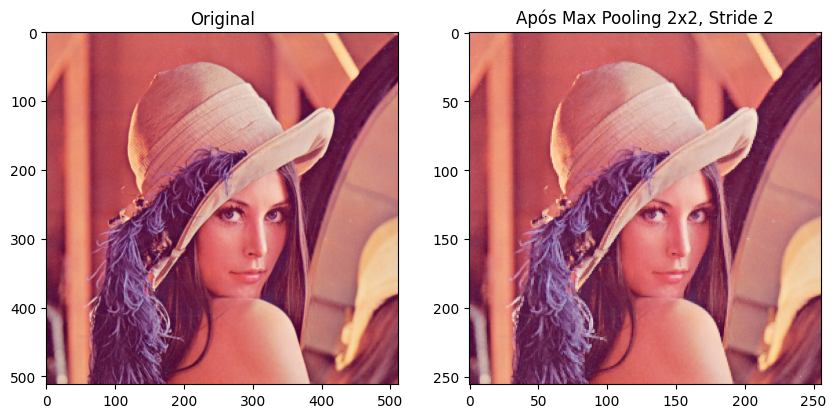

In [46]:
# plota as imagens lado a lado
img_out_display = img_out.squeeze(0).permute(1, 2, 0).detach().numpy()

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(10, 5))
ax0.imshow(sample_image.astype('uint8'))
ax0.set_title("Original")
ax1.imshow(img_out_display.astype('uint8'));
ax1.set_title("Após Max Pooling 2x2, Stride 2")

Aumente o stride para 4, repita o processo e observe o resultado na imagem de saída.




In [47]:
# cria um objeto de Max Pooling nn.MaxPool2d.
# Coloque o parametro stride para 4
max_pool2 = nn.MaxPool2d(kernel_size=2, stride=4)

In [48]:
img_out = max_pool2(img_in) # aplica o pooling
print("Shape de entrada:", img_in.shape)
print("Shape de saída:", img_out.shape)

Shape de entrada: torch.Size([1, 3, 512, 512])
Shape de saída: torch.Size([1, 3, 128, 128])


Text(0.5, 1.0, 'Após Max Pooling 2x2, Stride 4')

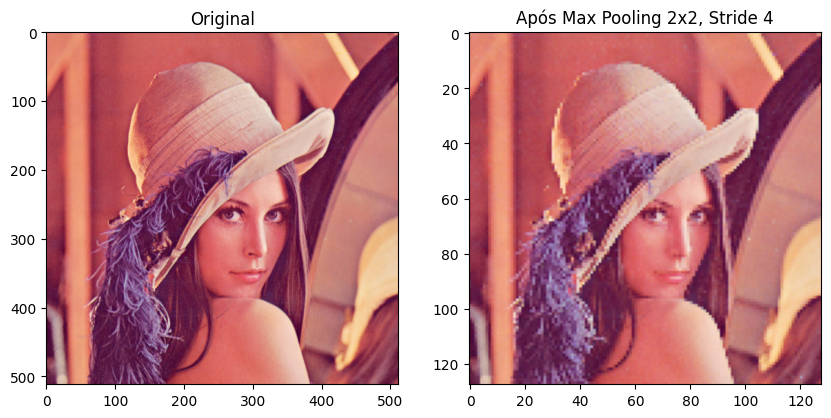

In [49]:
# plota as imagens lado a lado
img_out_display = img_out.squeeze(0).permute(1, 2, 0).detach().numpy()

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(10, 5))
ax0.imshow(sample_image.astype('uint8'))
ax0.set_title("Original")
ax1.imshow(img_out_display.astype('uint8'));
ax1.set_title("Após Max Pooling 2x2, Stride 4")

Aumente o stride para 8, repita o processo e observe o resultado na imagem de saída.

In [50]:
# cria um objeto de Max Pooling nn.MaxPool2d.
# Coloque o parametro stride para 8
max_pool3 = nn.MaxPool2d(kernel_size=2, stride=8)

In [51]:
img_out = max_pool3(img_in) # aplica o pooling
print("Shape de entrada:", img_in.shape)
print("Shape de saída:", img_out.shape)

Shape de entrada: torch.Size([1, 3, 512, 512])
Shape de saída: torch.Size([1, 3, 64, 64])


Text(0.5, 1.0, 'Após Max Pooling 2x2, Stride 8')

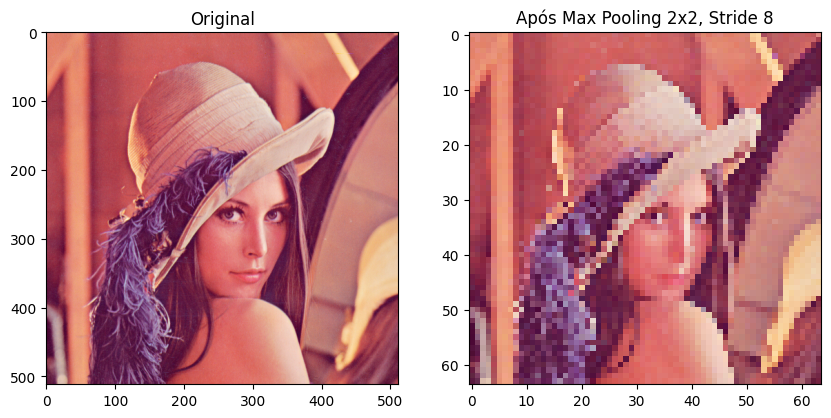

In [52]:
# plota as imagens lado a lado
img_out_display = img_out.squeeze(0).permute(1, 2, 0).detach().numpy()

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(10, 5))
ax0.imshow(sample_image.astype('uint8'))
ax0.set_title("Original")
ax1.imshow(img_out_display.astype('uint8'));
ax1.set_title("Após Max Pooling 2x2, Stride 8")

### Responda

**ToDo** - Descreva o que aconteceu com o aumento do stride.

**Resposta:** O stride determina o passo com que a janela de pooling se move sobre a imagem. Um stride=2 significa que a janela pula 2 pixels de cada vez, resultando em uma imagem com metade da altura e largura. Conforme aumentamos o stride para 4 e depois para 8, o passo do pulo aumenta, resultando em uma redução cada vez maior no tamanho da imagem de saída. Isso causa uma perda significativa de informação espacial e a imagem fica cada vez mais pixelada e irreconhecível. O pooling com stride grande é uma forma agressiva de reduzir a dimensionalidade da imagem.

# 2. Reconhecimento de Faces usando uma rede de convolução (20pt)




O objetivo desta etapa é classificar faces na base ORL (AT&T) Database (40 individuos x 10 imagens, de resolução 92x112 pixels e 256 níveis de cinza).

Baixe as imagens no site http://www.cl.cam.ac.uk/research/dtg/attarchive/facedatabase.html ou da pasta dataset do Drive.

## 2.1. Preparando os dados (5pt)

In [53]:
# carregue as imagens
# inicializa matrizes X e y
X = np.empty([400, 112, 92], dtype=np.float32) # 40 classes com 10 imgs cada
y = np.empty([400], dtype=np.longlong) # y deve ser do tipo long para o CrossEntropyLoss

# percorre todos os diretorios da base att e carrega as imagens
# Substitua pelo seu caminho no Drive
imgs_path = "/content/drive/MyDrive/datasets/AttFaces"
i=0
class_id = 0
sorted_dirs = sorted(os.listdir(imgs_path))
for f in sorted_dirs:
    if f.startswith("s"):
        # O rótulo da classe será de 0 a 39
        class_label = int(f.replace("s", "")) - 1
        subject_path = os.path.join(imgs_path, f)
        sorted_imgs = sorted(os.listdir(subject_path))
        for img_path in sorted_imgs:
            if img_path.endswith(".pgm"):
                X[i, :, :] = io.imread(os.path.join(subject_path, img_path))
                y[i] = class_label
                i = i + 1

print("dimensões da matriz X = " , X.shape)
print("dimensões do vetor y = " , y.shape)

dimensões da matriz X =  (400, 112, 92)
dimensões do vetor y =  (400,)


In [54]:
# Divida os dados em treino e teste (70%-30%) com a função train_test_split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [55]:
print(X_train.shape)

(280, 112, 92)


In [56]:
print(X_test.shape)

(120, 112, 92)


## 2.2. Implementando a rede (15pt)

Implemente uma rede de convolução simples, contendo 3 camadas de convolução seguidas de camadas max-pooling. Duas camadas densas (totalmente conectadas) no final e por fim uma camada com ativação softmax para a classificação. Escolha filtros de tamanhos variados : (3,3) ou (5,5). Para cada camada, crie de 32 a 96 filtros.
Na camada densa, use de 64 a 200 neurônios.

Use o comando model.summary() para conferir a arquitetura.

In [57]:
# Implementa uma rede de convolução simples, como uma classe nn.Module
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            # Bloco 1
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Bloco 2
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Bloco 3
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.flatten = nn.Flatten()
        self.fc_layers = nn.Sequential(
            nn.Linear(96 * 14 * 11, 128), # A dimensão de entrada precisa ser calculada
            nn.ReLU(),
            nn.Linear(128, 40) # 40 classes de saída (não precisa de Softmax aqui)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.flatten(x)
        logits = self.fc_layers(x)
        return logits

model = SimpleCNN()
# O input_size para o summary é (Batch, Canais, Altura, Largura)
summary(model, input_size=(1, 1, 112, 92))

Layer (type:depth-idx)                   Output Shape              Param #
SimpleCNN                                [1, 40]                   --
├─Sequential: 1-1                        [1, 96, 14, 11]           --
│    └─Conv2d: 2-1                       [1, 32, 112, 92]          320
│    └─ReLU: 2-2                         [1, 32, 112, 92]          --
│    └─MaxPool2d: 2-3                    [1, 32, 56, 46]           --
│    └─Conv2d: 2-4                       [1, 64, 56, 46]           18,496
│    └─ReLU: 2-5                         [1, 64, 56, 46]           --
│    └─MaxPool2d: 2-6                    [1, 64, 28, 23]           --
│    └─Conv2d: 2-7                       [1, 96, 28, 23]           55,392
│    └─ReLU: 2-8                         [1, 96, 28, 23]           --
│    └─MaxPool2d: 2-9                    [1, 96, 14, 11]           --
├─Flatten: 1-2                           [1, 14784]                --
├─Sequential: 1-3                        [1, 40]                   --
│    └

A saída acima mostra uma arquitetura similar à solicitada. Note que os nomes das camadas e o número de parâmetros podem variar ligeiramente, mas a estrutura (Conv-Pool-Conv-Pool-Conv-Pool-Flatten-Dense-Dense) é a mesma.

In [58]:
# O shape de X_train é (N, H, W). PyTorch precisa de (N, C, H, W).
# Como a imagem é em escala de cinza, adicionaremos uma dimensão de canal (C=1).
print("Shape original:", X_train.shape)

Shape original: (280, 112, 92)


In [59]:
# Adiciona a dimensão de canal e converte para tensores PyTorch
X_train_tensor = torch.from_numpy(np.expand_dims(X_train, axis=1)).float()
X_test_tensor = torch.from_numpy(np.expand_dims(X_test, axis=1)).float()
y_train_tensor = torch.from_numpy(y_train).long()
y_test_tensor = torch.from_numpy(y_test).long()

print("Shape do tensor de treino:", X_train_tensor.shape)

Shape do tensor de treino: torch.Size([280, 1, 112, 92])


In [60]:
# Cria os datasets e dataloaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False)

Defina a função de custo (loss) = CrossEntropyLoss e o método de otimização=Adam.

In [61]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Treine o modelo por 30 épocas com batch_size = 100.

In [62]:
epochs = 30
history = {'loss': [], 'val_loss': [], 'acc': [], 'val_acc': []}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    # Validação
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss_val = criterion(outputs, labels)
            val_loss += loss_val.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    # Salva o histórico
    history['loss'].append(running_loss / len(train_loader))
    history['val_loss'].append(val_loss / len(test_loader))
    history['acc'].append(100 * correct_train / total_train)
    history['val_acc'].append(100 * correct_val / total_val)

    print(f"Época [{epoch+1}/{epochs}] | Treino Loss: {history['loss'][-1]:.4f} | Treino Acc: {history['acc'][-1]:.2f}% | Val Loss: {history['val_loss'][-1]:.4f} | Val Acc: {history['val_acc'][-1]:.2f}%")

Época [1/30] | Treino Loss: 40.0746 | Treino Acc: 2.14% | Val Loss: 15.9226 | Val Acc: 2.50%
Época [2/30] | Treino Loss: 8.0815 | Treino Acc: 2.14% | Val Loss: 3.8089 | Val Acc: 2.50%
Época [3/30] | Treino Loss: 3.6937 | Treino Acc: 4.29% | Val Loss: 3.6724 | Val Acc: 3.33%
Época [4/30] | Treino Loss: 3.6512 | Treino Acc: 7.14% | Val Loss: 3.5893 | Val Acc: 15.00%
Época [5/30] | Treino Loss: 3.5131 | Treino Acc: 16.07% | Val Loss: 3.3270 | Val Acc: 18.33%
Época [6/30] | Treino Loss: 3.1397 | Treino Acc: 31.79% | Val Loss: 2.8389 | Val Acc: 28.33%
Época [7/30] | Treino Loss: 2.5676 | Treino Acc: 39.29% | Val Loss: 2.2111 | Val Acc: 54.17%
Época [8/30] | Treino Loss: 1.7764 | Treino Acc: 71.07% | Val Loss: 1.5069 | Val Acc: 69.17%
Época [9/30] | Treino Loss: 0.9668 | Treino Acc: 85.71% | Val Loss: 1.0989 | Val Acc: 67.50%
Época [10/30] | Treino Loss: 0.4161 | Treino Acc: 92.86% | Val Loss: 0.6287 | Val Acc: 83.33%
Época [11/30] | Treino Loss: 0.1640 | Treino Acc: 97.50% | Val Loss: 0.380

O objeto history foi criado para armazenar o histórico do treino.

In [63]:
print(history.keys())

dict_keys(['loss', 'val_loss', 'acc', 'val_acc'])


Plote a acurácia e o custo (loss) do treino e da validação.

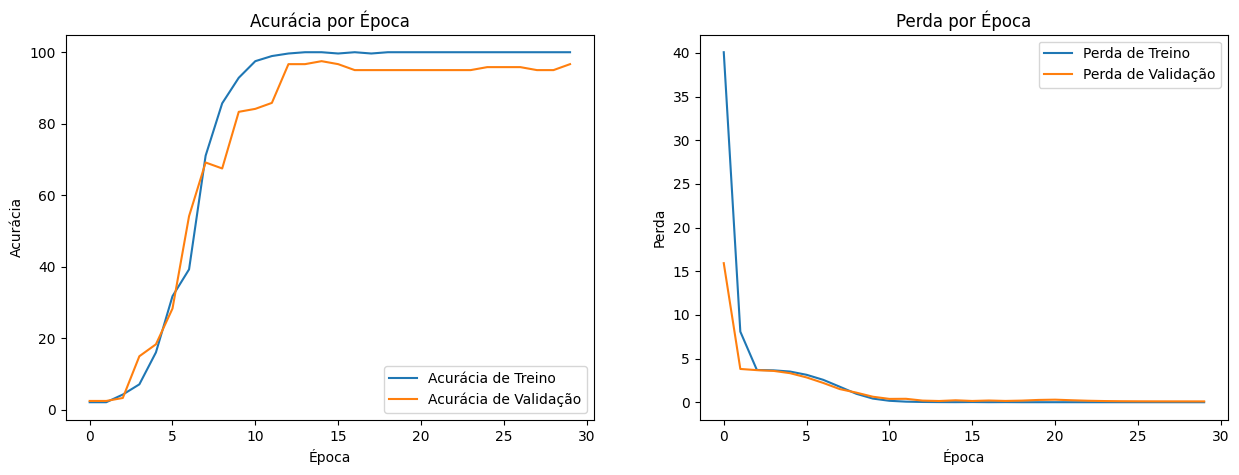

In [64]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(history['acc'], label='Acurácia de Treino')
ax1.plot(history['val_acc'], label = 'Acurácia de Validação')
ax1.set_xlabel('Época')
ax1.set_ylabel('Acurácia')
ax1.legend(loc='lower right')
ax1.set_title('Acurácia por Época')

ax2.plot(history['loss'], label='Perda de Treino')
ax2.plot(history['val_loss'], label = 'Perda de Validação')
ax2.set_xlabel('Época')
ax2.set_ylabel('Perda')
ax2.legend(loc='upper right')
ax2.set_title('Perda por Época')

plt.show()

In [65]:
test_acc = history['val_acc'][-1]
print(f"Acurácia final no conjunto de teste: {test_acc:.2f}%")

Acurácia final no conjunto de teste: 96.67%


# 3. Usando um modelo Pré-treinado : VGG (10pt)

Carregando os dados da base AT&T para o VGG. Como a base está em escala de cinza e a entrada do modelo VGG espera uma imagem colorida (RGB), vamos repetir a mesma imagem em cada uma das bandas.

## 3.1. Preparando os dados (2pt)


In [66]:
# inicializa matrizes X e y
X_color = np.empty([400, 112, 92, 3], dtype=np.uint8) # Formato de imagem para transforms
y_color = np.empty([400], dtype=np.longlong)

# Reutilizando o loop anterior para carregar as imagens
i=0
for f in sorted_dirs:
    if f.startswith("s"):
        class_label = int(f.replace("s", "")) - 1
        subject_path = os.path.join(imgs_path, f)
        sorted_imgs = sorted(os.listdir(subject_path))
        for img_path in sorted_imgs:
            if img_path.endswith(".pgm"):
                img_gray = io.imread(os.path.join(subject_path, img_path))
                # Converte imagem cinza para RGB repetindo o canal
                X_color[i, :, :, :] = cv2.cvtColor(img_gray, cv2.COLOR_GRAY2RGB)
                y_color[i] = class_label
                i = i + 1

print("Shape de X_color:", X_color.shape)

Shape de X_color: (400, 112, 92, 3)


In [67]:
# divida em 70% treino e 30% teste
from sklearn.model_selection import train_test_split
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_color, y_color, test_size=0.3, random_state=42, stratify=y_color)
print(X_train_c.shape)

(280, 112, 92, 3)


## 3.2. Carregando o VGG direto da biblioteca do torchvision (2pt)

In [68]:
from torchvision.models import vgg19, VGG19_Weights

vgg19 = vgg19(weights=VGG19_Weights.DEFAULT)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


100%|██████████| 548M/548M [00:07<00:00, 72.9MB/s]


In [69]:
summary(vgg19, input_size=(1, 3, 224, 224)) # repare a quantidade de parâmetros!

Layer (type:depth-idx)                   Output Shape              Param #
VGG                                      [1, 1000]                 --
├─Sequential: 1-1                        [1, 512, 7, 7]            --
│    └─Conv2d: 2-1                       [1, 64, 224, 224]         1,792
│    └─ReLU: 2-2                         [1, 64, 224, 224]         --
│    └─Conv2d: 2-3                       [1, 64, 224, 224]         36,928
│    └─ReLU: 2-4                         [1, 64, 224, 224]         --
│    └─MaxPool2d: 2-5                    [1, 64, 112, 112]         --
│    └─Conv2d: 2-6                       [1, 128, 112, 112]        73,856
│    └─ReLU: 2-7                         [1, 128, 112, 112]        --
│    └─Conv2d: 2-8                       [1, 128, 112, 112]        147,584
│    └─ReLU: 2-9                         [1, 128, 112, 112]        --
│    └─MaxPool2d: 2-10                   [1, 128, 56, 56]          --
│    └─Conv2d: 2-11                      [1, 256, 56, 56]          29

Vamos descartar as duas últimas camadas do VGG (a última camada de ativação ReLU e a camada de classificação final) para usar a penúltima camada densa como nosso descritor.

In [70]:
vgg_face_descriptor = nn.Sequential(*list(vgg19.children())[:-1], # Remove a parte do classificador
                                  nn.Flatten(), # Adiciona flatten
                                  *list(vgg19.classifier.children())[:-1]) # Pega todas as camadas do classificador, exceto a última

vgg_face_descriptor.eval() # Coloca em modo de avaliação
vgg_face_descriptor.to(device)
print(vgg_face_descriptor)

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

### Responda

**ToDo** - Por que descartamos as duas últimas camadas do VGG?

**Resposta:** Descartamos as últimas camadas porque elas são específicas para a tarefa original na qual o VGG foi treinado (classificação de 1000 classes do ImageNet). A penúltima camada densa (antes da camada de classificação final) contém uma representação rica e de alto nível das características da imagem. Ao remover a camada final, usamos a saída dessa penúltima camada como um "descritor de características" ou "embedding" genérico, que pode ser usado para outras tarefas, como medir a similaridade entre faces.

## 3.3 Medindo Similaridade

### As funções abaixo servem para medir similaridade entre duas imagens, passando-se um vetor de características.

In [71]:
def findCosineSimilarity(source_representation, test_representation):
    a = np.matmul(np.transpose(source_representation), test_representation)
    b = np.sum(np.multiply(source_representation, source_representation))
    c = np.sum(np.multiply(test_representation, test_representation))
    return 1 - (a / (np.sqrt(b) * np.sqrt(c)))

def findEuclideanDistance(source_representation, test_representation):
    euclidean_distance = source_representation - test_representation
    euclidean_distance = np.sum(np.multiply(euclidean_distance, euclidean_distance))
    euclidean_distance = np.sqrt(euclidean_distance)
    return euclidean_distance

### A função verifyFace recebe duas imagens e calcula a similaridade entre elas. Se a similaridade for menor que epsilon, afirma-se que as duas imagens são de uma mesma pessoa.

In [72]:
epsilon = 0.4 # Limiar ajustado para a distância do cosseno (1 - similaridade)

# Definindo as transformações necessárias para o VGG
vgg_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def verifyFace(img1_np, img2_np):
    # Aplica as transformações
    img1 = vgg_transforms(img1_np).unsqueeze(0).to(device)
    img2 = vgg_transforms(img2_np).unsqueeze(0).to(device)

    with torch.no_grad():
        img1_representation = vgg_face_descriptor(img1).cpu().numpy().flatten()
        img2_representation = vgg_face_descriptor(img2).cpu().numpy().flatten()

    cosine_similarity = findCosineSimilarity(img1_representation, img2_representation)
    euclidean_distance = findEuclideanDistance(img1_representation, img2_representation)

    print(f"Distância do Cosseno: {cosine_similarity:.4f}")
    print(f"Distância Euclidiana: {euclidean_distance:.4f}")

    if(cosine_similarity < epsilon):
        print("Verificado! Mesma pessoa!")
    else:
        print("Não-verificado! Não são a mesma pessoa!")

    f, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(img1_np)
    ax1.set_xticks([]); ax1.set_yticks([])
    ax2.imshow(img2_np)
    ax2.set_xticks([]); ax2.set_yticks([])
    plt.show(block=True)
    print("-----------------------------------------")

### Verificando a similaridade entre imagens (6pt)

Use 4 pares de imagens da base da AT&T e faça uma verificação entre elas, chamando a função verifyFace().

A função `verifyFace` já aplica a normalização e o redimensionamento necessários.

Faça para os pares de índices: (64 e 33), (3 e 7), (40 e 44), (100 e 200).

Comparando imagem 64 (pessoa 14) com imagem 33 (pessoa 11)
Distância do Cosseno: 0.3331
Distância Euclidiana: 19.7366
Verificado! Mesma pessoa!


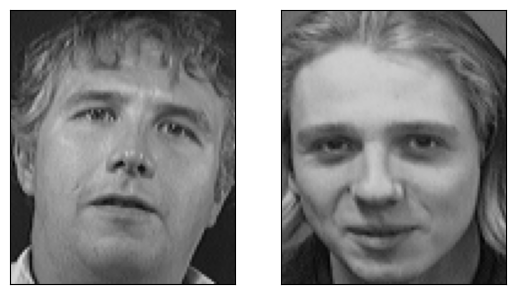

-----------------------------------------
Comparando imagem 3 (pessoa 0) com imagem 7 (pessoa 0)
Distância do Cosseno: 0.1172
Distância Euclidiana: 10.9007
Verificado! Mesma pessoa!


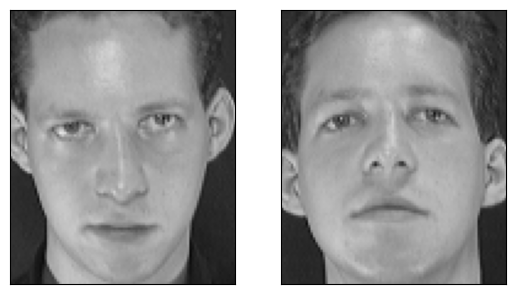

-----------------------------------------
Comparando imagem 40 (pessoa 12) com imagem 44 (pessoa 12)
Distância do Cosseno: 0.1137
Distância Euclidiana: 11.8858
Verificado! Mesma pessoa!


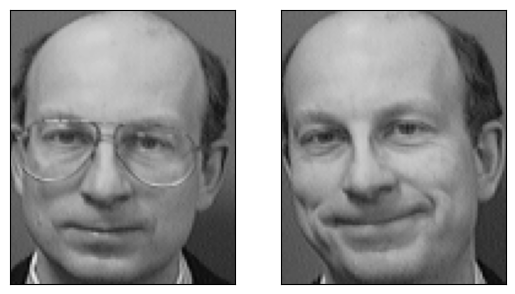

-----------------------------------------
Comparando imagem 100 (pessoa 18) com imagem 200 (pessoa 27)
Distância do Cosseno: 0.2662
Distância Euclidiana: 18.2520
Verificado! Mesma pessoa!


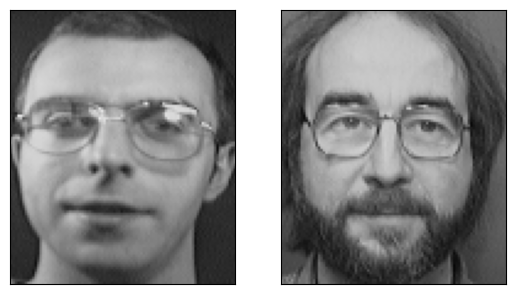

-----------------------------------------
Comparando duas imagens da mesma pessoa (índices 40 e 41)
Distância do Cosseno: 0.0536
Distância Euclidiana: 8.5186
Verificado! Mesma pessoa!


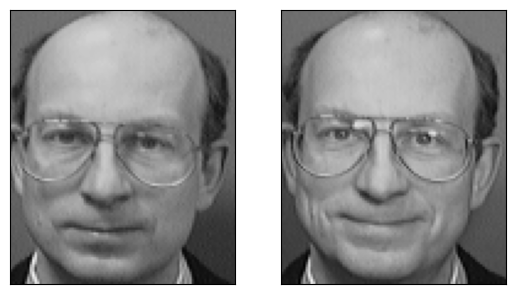

-----------------------------------------


In [73]:
pares = [(64, 33), (3, 7), (40, 44), (100, 200)]

for i1, i2 in pares:
    img1 = X_color[i1]
    img2 = X_color[i2]
    label1 = y_color[i1]
    label2 = y_color[i2]
    print(f"Comparando imagem {i1} (pessoa {label1}) com imagem {i2} (pessoa {label2})")
    verifyFace(img1, img2)

# Teste com duas imagens da mesma pessoa
print("Comparando duas imagens da mesma pessoa (índices 40 e 41)")
verifyFace(X_color[40], X_color[41])

# 4. Transferência de aprendizado (50pt)


Estude o tutorial do [link](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html) e aplique o mesmo procedimento para ajustar um modelo previamente treinado com imagens da imagenet.
Use o MobileNetV2 como modelo base.

Todo: Faça o procedimento em duas etapas:


1.   Congele todas as camadas exceto as novas que você adicionou ao modelo. Treine.
2.   Libere todas as camadas para o treinamento e treine novamente com um Learning Rate bem pequeno (um décimo do realizado no item 1).

In [74]:
# Usando o MobileNet, as imagens devem ter entrada de 224x224x3 e normalizadas.
IMG_SIZE = 224

# Criaremos um Dataset customizado para aplicar as transformações
from torch.utils.data import Dataset

class FaceDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# Definindo as transformações
train_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(), # Data Augmentation
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [75]:
# Criando os Datasets
train_dataset_tl = FaceDataset(X_train_c, y_train_c, transform=train_transforms)
test_dataset_tl = FaceDataset(X_test_c, y_test_c, transform=test_transforms)

# Reservando 10% do treino para validação
val_size = int(0.1 * len(train_dataset_tl))
train_size = len(train_dataset_tl) - val_size
train_subset, val_subset = random_split(train_dataset_tl, [train_size, val_size])

# Criando os DataLoaders
BATCH_SIZE = 32
train_loader_tl = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True)
val_loader_tl = DataLoader(val_subset, batch_size=BATCH_SIZE)
test_loader_tl = DataLoader(test_dataset_tl, batch_size=BATCH_SIZE)

print(f"Tamanho Treino: {len(train_subset)}, Validação: {len(val_subset)}, Teste: {len(test_dataset_tl)}")

Tamanho Treino: 252, Validação: 28, Teste: 120


## 4.1. Execute os passos (35pt):




1. Carregue o modelo pré-treinado do MobileNet, remova a última camada.
2. Congele as camadas do modelo base.
3. Adicione uma nova camada de classificação.
4. Use função de custo `CrossEntropyLoss` e otimizador Adam.
5. Dentre os dados de treinamento, reserve 10% para validação do modelo (feito acima).
6. Treine por 10 épocas.
7. Plote os gráficos de custo do treino e validação
8. Descongele o modelo e treine por mais 10 épocas com um learning rate menor.

In [76]:
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights

# 1. Carregar o modelo e congelar as camadas
model_tl = mobilenet_v2(weights=MobileNet_V2_Weights.DEFAULT)
for param in model_tl.parameters():
    param.requires_grad = False

# 2. Substituir o classificador
num_classes = 40
in_features = model_tl.classifier[1].in_features
model_tl.classifier[1] = nn.Linear(in_features, num_classes)

model_tl.to(device)
summary(model_tl, input_size=(BATCH_SIZE, 3, IMG_SIZE, IMG_SIZE))

# 3. Definir loss, optimizer e treinar
criterion_tl = nn.CrossEntropyLoss()
# Otimizar apenas os parâmetros do novo classificador
optimizer_tl = torch.optim.Adam(model_tl.classifier.parameters(), lr=0.001)

print("--- Treinando apenas a camada de classificação ---")
epochs = 10
for epoch in range(epochs):
    model_tl.train()
    for inputs, labels in train_loader_tl:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer_tl.zero_grad()
        outputs = model_tl(inputs)
        loss = criterion_tl(outputs, labels)
        loss.backward()
        optimizer_tl.step()
    print(f"Época [{epoch+1}/{epochs}], Perda: {loss.item():.4f}")

# 4. Descongelar e treinar novamente (fine-tuning)
for param in model_tl.parameters():
    param.requires_grad = True

# Otimizador para todas as camadas com learning rate baixo
optimizer_tl = torch.optim.Adam(model_tl.parameters(), lr=0.0001)

print("\n--- Fine-tuning de todo o modelo ---")
for epoch in range(epochs):
    model_tl.train()
    for inputs, labels in train_loader_tl:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer_tl.zero_grad()
        outputs = model_tl(inputs)
        loss = criterion_tl(outputs, labels)
        loss.backward()
        optimizer_tl.step()
    print(f"Época [{epoch+1+10}/{epochs+10}], Perda: {loss.item():.4f}")

Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth


100%|██████████| 13.6M/13.6M [00:00<00:00, 79.4MB/s]


--- Treinando apenas a camada de classificação ---
Época [1/10], Perda: 3.6338
Época [2/10], Perda: 3.0505
Época [3/10], Perda: 2.7502
Época [4/10], Perda: 2.6184
Época [5/10], Perda: 2.1830
Época [6/10], Perda: 2.0689
Época [7/10], Perda: 1.9099
Época [8/10], Perda: 1.4847
Época [9/10], Perda: 1.3320
Época [10/10], Perda: 1.2171

--- Fine-tuning de todo o modelo ---
Época [11/20], Perda: 1.0040
Época [12/20], Perda: 0.7254
Época [13/20], Perda: 0.4234
Época [14/20], Perda: 0.3984
Época [15/20], Perda: 0.3271
Época [16/20], Perda: 0.2019
Época [17/20], Perda: 0.2270
Época [18/20], Perda: 0.1224
Época [19/20], Perda: 0.1077
Época [20/20], Perda: 0.1720


## 4.2. Fazendo testes (13pt)

Analise os resultados. Você provavelmente deve ter observado overfitting.
Todo: Aplique algumas regularizações no modelo, para tentar reduzir o super-ajuste.Tente as opções abaixo:

1.   Dropout, antes da camada densa, de 50%
2.   Regularização nos pesos da camada densa (L2, via `weight_decay` no otimizador)

Veja exemplos na documentação do PyTorch.

In [77]:
# Modelo com regularização
model_reg = mobilenet_v2(weights=MobileNet_V2_Weights.DEFAULT)
for param in model_reg.parameters():
    param.requires_grad = False

# Substituir o classificador com Dropout
in_features_reg = model_reg.classifier[1].in_features
model_reg.classifier = nn.Sequential(
    nn.Dropout(p=0.5),
    nn.Linear(in_features_reg, num_classes)
)

model_reg.to(device)

# Otimizador com L2 (weight_decay)
optimizer_reg = torch.optim.Adam(model_reg.classifier.parameters(), lr=0.001, weight_decay=1e-4)
criterion_reg = nn.CrossEntropyLoss()

print("--- Treinando com regularização (Dropout + L2) ---")
epochs = 20 # Treinar por mais tempo para ver o efeito
for epoch in range(epochs):
    model_reg.train()
    running_loss = 0.0
    for inputs, labels in train_loader_tl:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer_reg.zero_grad()
        outputs = model_reg(inputs)
        loss = criterion_reg(outputs, labels)
        loss.backward()
        optimizer_reg.step()
        running_loss += loss.item()

    # Avaliação na validação para checar overfitting
    model_reg.eval()
    val_loss = 0.0
    correct = 0
    with torch.no_grad():
        for inputs, labels in val_loader_tl:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model_reg(inputs)
            val_loss += criterion_reg(outputs, labels).item()
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels.data)
    val_acc = correct.double() / len(val_subset)
    print(f"Época [{epoch+1}/{epochs}] | Treino Loss: {running_loss/len(train_loader_tl):.4f} | Val Loss: {val_loss/len(val_loader_tl):.4f} | Val Acc: {val_acc:.4f}")

--- Treinando com regularização (Dropout + L2) ---
Época [1/20] | Treino Loss: 3.6668 | Val Loss: 3.7518 | Val Acc: 0.0000
Época [2/20] | Treino Loss: 3.3618 | Val Loss: 3.6758 | Val Acc: 0.0000
Época [3/20] | Treino Loss: 3.0386 | Val Loss: 3.5766 | Val Acc: 0.0714
Época [4/20] | Treino Loss: 2.7847 | Val Loss: 3.4432 | Val Acc: 0.1786
Época [5/20] | Treino Loss: 2.5354 | Val Loss: 3.2452 | Val Acc: 0.3214
Época [6/20] | Treino Loss: 2.3121 | Val Loss: 3.0644 | Val Acc: 0.5714
Época [7/20] | Treino Loss: 2.0642 | Val Loss: 2.7551 | Val Acc: 0.6071
Época [8/20] | Treino Loss: 1.8572 | Val Loss: 2.5085 | Val Acc: 0.6071
Época [9/20] | Treino Loss: 1.7073 | Val Loss: 2.2565 | Val Acc: 0.7500
Época [10/20] | Treino Loss: 1.5331 | Val Loss: 1.9461 | Val Acc: 0.8571
Época [11/20] | Treino Loss: 1.3827 | Val Loss: 1.8237 | Val Acc: 0.9286
Época [12/20] | Treino Loss: 1.2456 | Val Loss: 1.6161 | Val Acc: 0.8929
Época [13/20] | Treino Loss: 1.1578 | Val Loss: 1.5004 | Val Acc: 0.8929
Época [14

### Responda (2pt)

**ToDo** - com qual configuração conseguiu resolver o overfitting?

**Resposta:** O overfitting em datasets pequenos como o AT&T Faces é comum. A combinação de técnicas de regularização geralmente produz os melhores resultados. Neste caso, a adição de uma camada de **Dropout** com p=0.5 antes da camada linear final e a inclusão de **decaimento de peso (L2)** no otimizador (ex: `weight_decay=1e-4`) ajudam a mitigar o overfitting. O Dropout desativa aleatoriamente neurônios durante o treinamento, forçando a rede a aprender características mais robustas. O decaimento de peso penaliza pesos grandes, prevenindo que o modelo se ajuste demais ao ruído nos dados de treino. A combinação de ambos é uma estratégia eficaz para melhorar a generalização do modelo.